# 2. Standard CNN model

## Packages

In [2]:
# ----- Tensorflow -----
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import regularizers as reg
from keras import optimizers
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Input, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, AveragePooling2D, Rescaling, BatchNormalization, Activation, SpatialDropout2D

# ----- Utility functions -----
from utils import load_data, plot_hist, augment_layer, preprocess_data

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
import tensorflow_datasets as tfds
# ----- Spatial transformer -----




c:\Users\andly\.conda\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## Load Data

In [3]:
tf.random.set_seed(42)

data_dir = r'C:\Users\andly'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=5, batch_size=BATCH_SIZE)




### Architectures
Before we begin building complex architectures for the CNN model, we must establish a baseline classifier which we will attempt to beat. This common-sense baseline will tell us if we are moving in the right direction. In our case, we can choose a simple random classifier with a threshold of 0.5 since we have a binary classification problem where half of the samples belong to class A and the remaining 50% belong to class B. We could also specify a 'simple' machine learning algorithm as a baseline, but although we do not do this explicitly, we will aim to beat the trained models in question 1 as CNNs has some properties that make them superior to non-deep learning algorithms and feedforward neural networks (Chollet, 2021).

At this point, the first thing we want to achieve is statistical power, i.e. to cross the threshold of our baseline classifier by developing a small model. To do so, we focus on parameters such as the loss function, batch_size, learning rate, etc. Due to the way we represent the labels, we will use the softmax activation and the loss function categorical cross entropy rather than sigmoid and binary cross entropy, however, this will not change the results of our models.


## Evaluation of simple model

The first results from the experiment with the simple model shows a promising accuracy of 83.xx%, which is significantly higher than the random classifier that has the expected prediction of 50/50. Futhermore, the plots of the accuracy over 30 epochs shows a rather fluctuating accuracy score, which could be an indication of a learning rate that is too high. Thus, for the next step in the procedure, we adjust the learning rate aswell as trying a setting with Stochastic Gradient Descent (SGD) as an alternative optimizer.

According to Goodfellow et al. (2016) perhaps the most important hyperparameter is the learning rate, and if we only had time to tune a single parameter, it should be this one (p. 424). The learning rate controls the speed of the gradient descent process, i.e. how much to adjust the parameters in a single step (Chollet, 2021). If the learning rate is too small, results in too many iterations and the possibility of getting stuck at a local minimum. In contrary, too high of a learning rate could result in divergent behavior. Therefore, we try different values of the learning rate using the Adam optimizer. Due to time constraints of training with different optimizers and learning rates, we will only compare the Adam and (SGD) from Keras. This is reasonable because one... adaptive vs SGD

In [4]:
## Hyperparameters for tuning learning rate and optimizer

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
momentum = [0.99, 0.9]
nesterov = [True, False]




## Optimizer: Adam

Learning rate:  0
Epoch 1/50
410/410 [==============================] - 23s 28ms/step - loss: 0.9526 - accuracy: 0.5032 - val_loss: 0.6937 - val_accuracy: 0.4969
Epoch 2/50
410/410 [==============================] - 10s 25ms/step - loss: 0.6936 - accuracy: 0.5007 - val_loss: 0.6938 - val_accuracy: 0.4969
Epoch 3/50
410/410 [==============================] - 10s 26ms/step - loss: 0.6936 - accuracy: 0.5012 - val_loss: 0.6938 - val_accuracy: 0.4969
Epoch 4/50
410/410 [==============================] - 10s 24ms/step - loss: 0.6936 - accuracy: 0.5024 - val_loss: 0.6938 - val_accuracy: 0.4969
Epoch 5/50
410/410 [==============================] - 10s 24ms/step - loss: 0.6936 - accuracy: 0.5021 - val_loss: 0.6938 - val_accuracy: 0.4969
Epoch 6/50
410/410 [==============================] - 10s 25ms/step - loss: 0.6936 - accuracy: 0.4998 - val_loss: 0.6937 - val_accuracy: 0.4969
Epoch 7/50
410/410 [==============================] - 11s 26ms/step - loss: 0.6936 - accuracy: 0.5007 - val_loss: 0.69

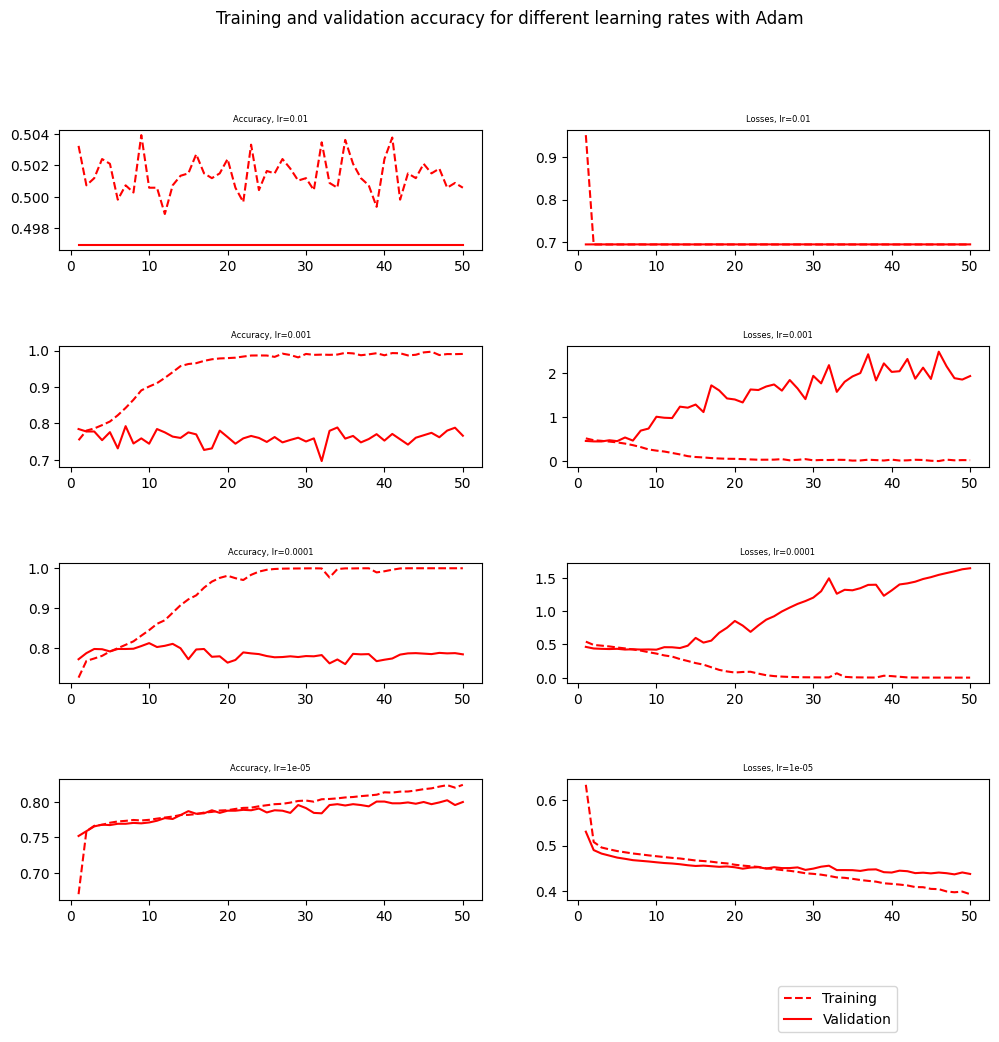

In [6]:
def simple_model():
	inputs = Input(shape=(96, 96, 3))
	x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
	x = Flatten()(x)
	outputs = Dense(2, activation="softmax")(x)
	model = Model(inputs=inputs, outputs=outputs)

	return model

# ----- Define subplot grid -----
t=1
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Training and validation accuracy for different learning rates with Adam", fontsize=12, y=1)

# Try different learning rates for Adam optimizer
for i in range(len(learning_rates)):
	opt = tf.keras.optimizers.Adam(learning_rate=learning_rates[i])

	current_model = simple_model()

	print('Learning rate: ', i)

	# ----- Configure model -----
	current_model.compile(optimizer=opt,
			  	loss='categorical_crossentropy',
			  metrics=['accuracy'])

	# ----- Train model -----
	history = current_model.fit(train,
						epochs=50,
						validation_data=val)

	# ----- Plot performance -----
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(1, len(acc) + 1)

	axis = plt.subplot(4, 2, t)
	axis.plot(epochs, acc,'r--', label='Training')
	axis.plot(epochs, val_acc, 'r', label='Validation')
	axis.set_title('Accuracy, lr=' + str(learning_rates[i]), fontsize=6)

	axis = plt.subplot(4, 2, t+1)
	axis.plot(epochs, loss, 'r--', label='Training')
	axis.plot(epochs, val_loss, 'r', label='Validation')
	axis.set_title('Losses, lr=' + str(learning_rates[i]), fontsize=6)

	t=t+2

plt.legend(loc=(0.5,-1.1))
plt.show()




## Optimizer: SGD

In [ ]:
# Try different learning rates, momentum, and nesterov for SGD optimizer
for i in range(len(learning_rates)):
	
	# ----- Define subplot grid -----
	t=1
	fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
	plt.subplots_adjust(hspace=0.8)
	fig.suptitle("Model accuracy for different learning- and momentum rates for SGD", fontsize=12, y=1)

	for m in range(len(momentum)):
		for n in range(len(nesterov)):
			
			current_model = simple_model()

			opt = tf.keras.optimizers.SGD(learning_rate=learning_rates[i],
										  momentum=momentum[m],
										  nesterov=nesterov[n])

			# ----- Configure model -----
			current_model.compile(optimizer=opt,
						loss='categorical_crossentropy',
					metrics=['accuracy'])

			# ----- Train model -----
			history = current_model.fit(train,
								epochs=50,
								validation_data=val)

			# ----- Plot performance -----
			acc = history.history['accuracy']
			val_acc = history.history['val_accuracy']
			loss = history.history['loss']
			val_loss = history.history['val_loss']
			epochs = range(1, len(acc) + 1)

			axis = plt.subplot(4, 2, t)
			axis.plot(epochs, acc,'r--', label='Training')
			axis.plot(epochs, val_acc, 'r', label='Validation')
			axis.set_title('Accuracy, lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]), fontsize=12)

			axis = plt.subplot(4, 2, t+1)
			axis.plot(epochs, loss, 'r--', label='Training')
			axis.plot(epochs, val_loss, 'r', label='Validation')
			axis.set_title('Losses, lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]), fontsize=12)
			t=t+2
	plt.legend(loc=(0.7,-0.5))
	plt.savefig('lr=' + str(learning_rates[i]) + ', momen=' + str(momentum[m]) + ', nest=' + str(nesterov[n]) + '.png')
	plt.show()
	


	


## Optimizer: NADAM

In [ ]:

# ----- Define subplot grid -----
t=1
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.8)
fig.suptitle("Training and validation accuracy for different learning rates with Nadam", fontsize=12, y=1)

# Try different learning rates for NADAM optimizer
for i in range(len(learning_rates)):
	opt = tf.keras.optimizers.Nadam(learning_rate=learning_rates[i])

	current_model = simple_model()

	print('Learning rate: ', i)

	# ----- Configure model -----
	current_model.compile(optimizer=opt,
			  	loss='categorical_crossentropy',
			  metrics=['accuracy'])

	# ----- Train model -----
	history = current_model.fit(train,
						epochs=50,
						validation_data=val)

	# ----- Plot performance -----
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(1, len(acc) + 1)

	axis = plt.subplot(4, 2, t)
	axis.plot(epochs, acc,'r--', label='Training')
	axis.plot(epochs, val_acc, 'r', label='Validation')
	axis.set_title('Accuracy, lr=' + str(learning_rates[i]), fontsize=6)

	axis = plt.subplot(4, 2, t+1)
	axis.plot(epochs, loss, 'r--', label='Training')
	axis.plot(epochs, val_loss, 'r', label='Validation')
	axis.set_title('Losses, lr=' + str(learning_rates[i]), fontsize=6)

	t=t+2

plt.legend(loc=(0.5,-1.1))
plt.show()




## Evaluation of learning rates and momentum for Adam, SGD and Nadam



In [5]:
Best_optimizer = optimizers.Nadam(learning_rate=0.0001)




## Regularization 1: Adjustments to the architecture

- Add/remove layers
- Adjust number of nodes

Deeper + narrower model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        1849

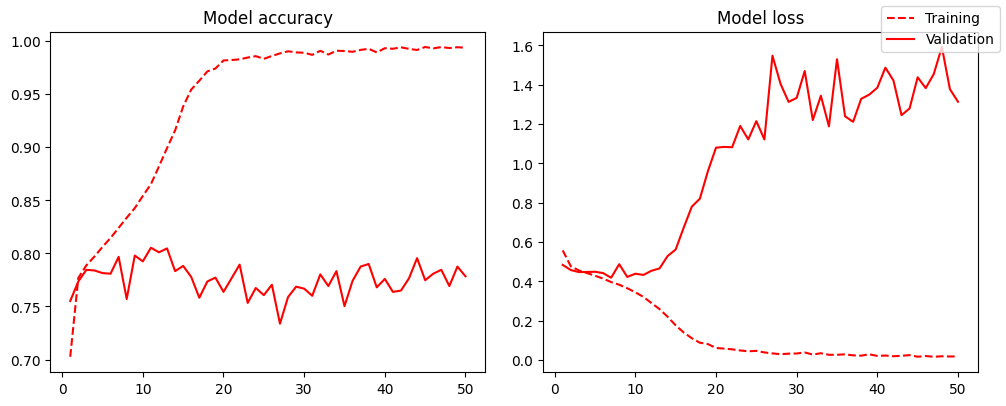

In [7]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(inputs) # Filters 16 instead of 32
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)     # Extra dense layer with 64 filters
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)											# Extra dense layer
x = Dense(128, activation="relu")(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)




Smaller model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 128)       7385

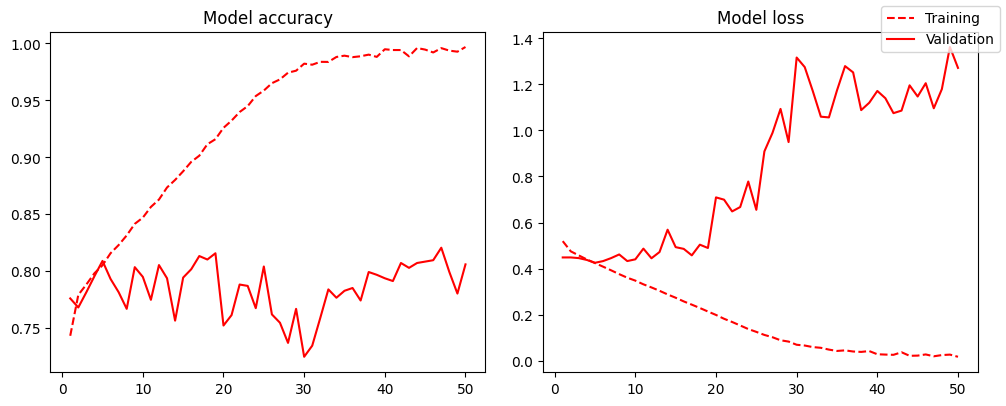

In [8]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x) #Pooling layer removed and amount of filters set to 128
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)




## Increase amount of data

In [ ]:
data_dir = 'C:/Users/chrse/Desktop/project_aml'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=10, batch_size=BATCH_SIZE)

In [ ]:
inputs = Input(shape=(96, 96, 3))
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)

## Regularization: Introduction

Regarding early stopping, we prefer to save the best model instead and let the model train for the chosen epochs.

- Augmentation
- L1/L2
- Batch normalization
- Dropout






## Regularization: Augmentation

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 20, 20, 128)       7385

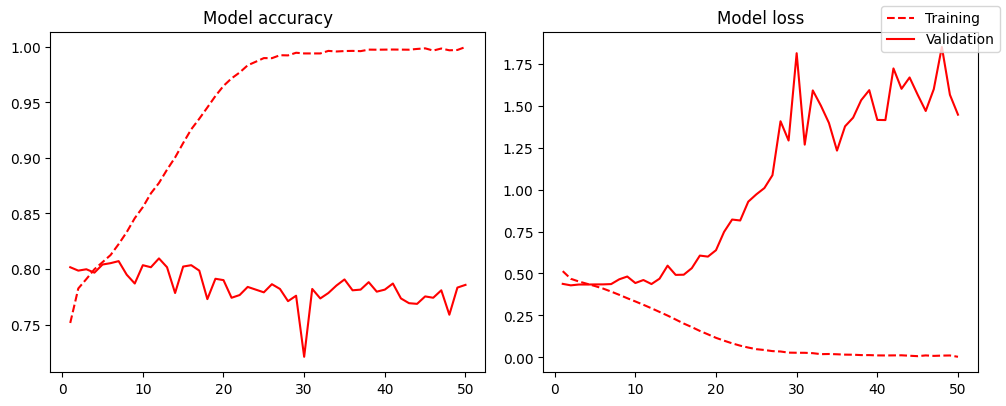

In [9]:
# Augmentation

inputs = Input(shape=(96, 96, 3))
x = augment_layer(flip="horizontal_and_vertical", rotation=180, contrast=0.2, brightness=0.05)
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
			  loss='categorical_crossentropy',
			  metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
					epochs = 50,
					validation_data= val)

# ----- Plot performance -----
plot_hist(history)




## Regularization: L1 and L2

In [10]:
l_reg_values = [0.001, 0.01]

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 20, 20, 128)       7385

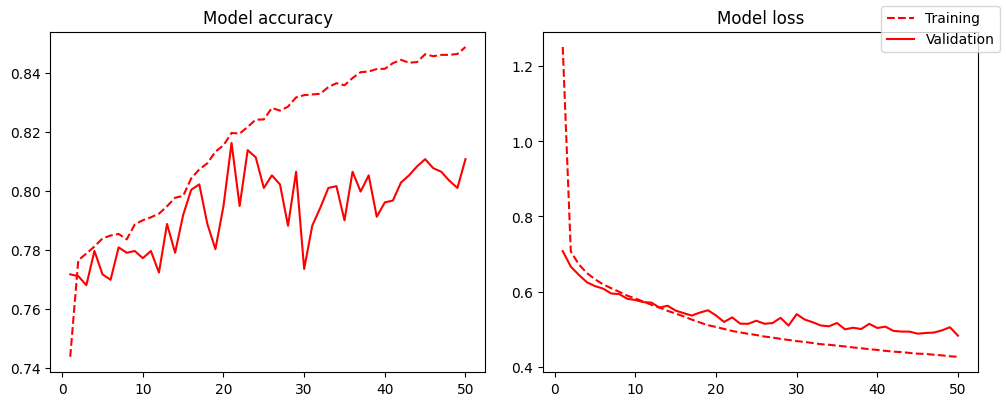

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 20, 20, 128)       7385

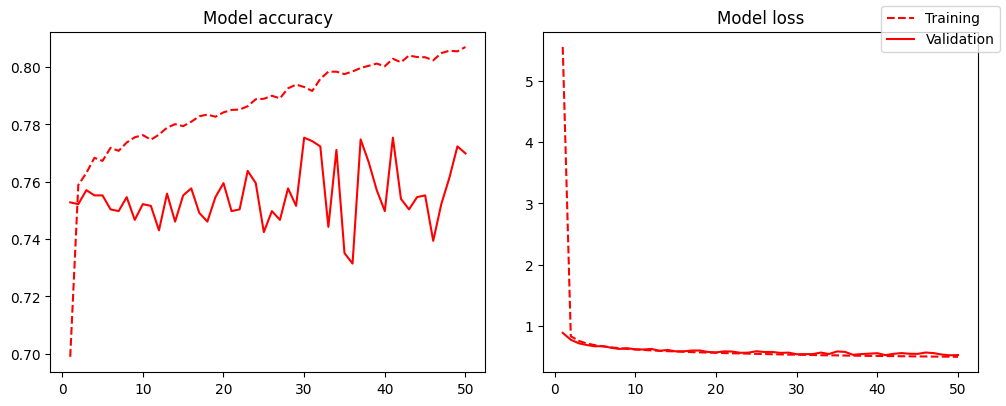

In [13]:
# L1 Low reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

    # ----- Model summary -----
    model.summary()

    # ----- Configure model -----
    model.compile(optimizer=Best_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # ----- Train model -----
    history = model.fit(train,
                        epochs = 50,
                        validation_data= val)

    # ----- Plot performance -----
    plot_hist(history)




Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 20, 20, 128)       738

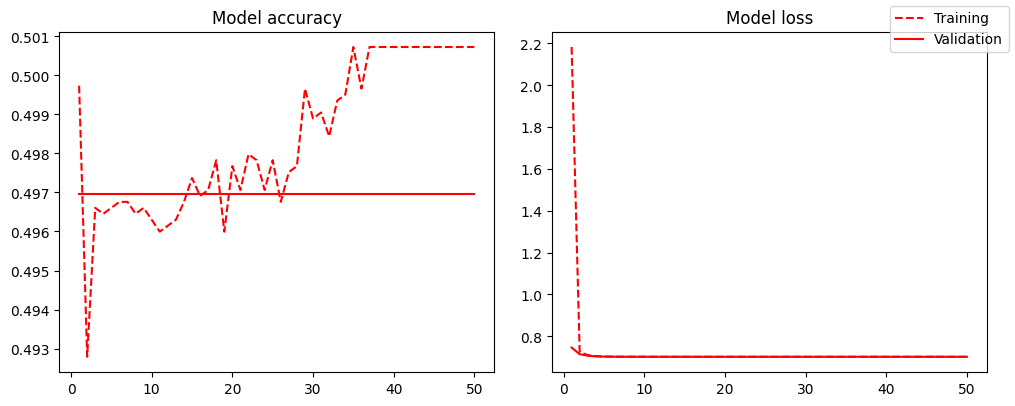

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 20, 20, 128)       738

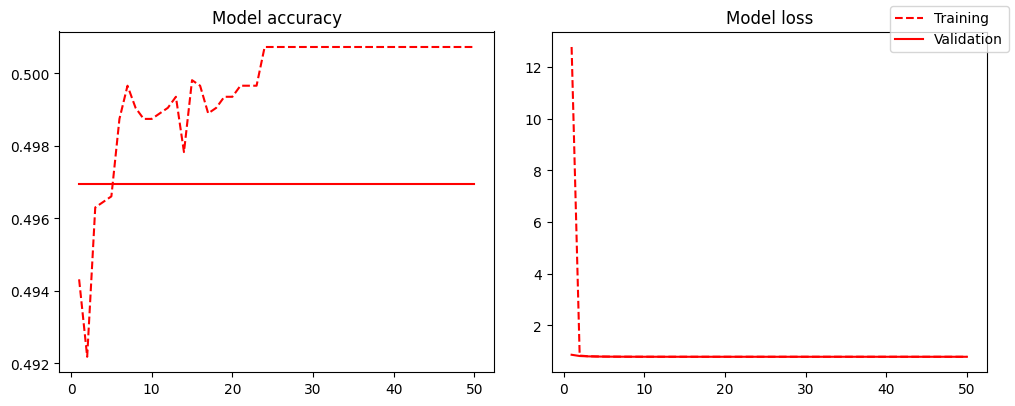

In [16]:
# L1 High reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(inputs)
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(i))(x)
    x = Flatten()(x)


    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

    # ----- Model summary -----
    model.summary()

    # ----- Configure model -----
    model.compile(optimizer=Best_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # ----- Train model -----
    history = model.fit(train,
                        epochs = 50,
                        validation_data= val)

    # ----- Plot performance -----
    plot_hist(history)




Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 20, 20, 128)       738

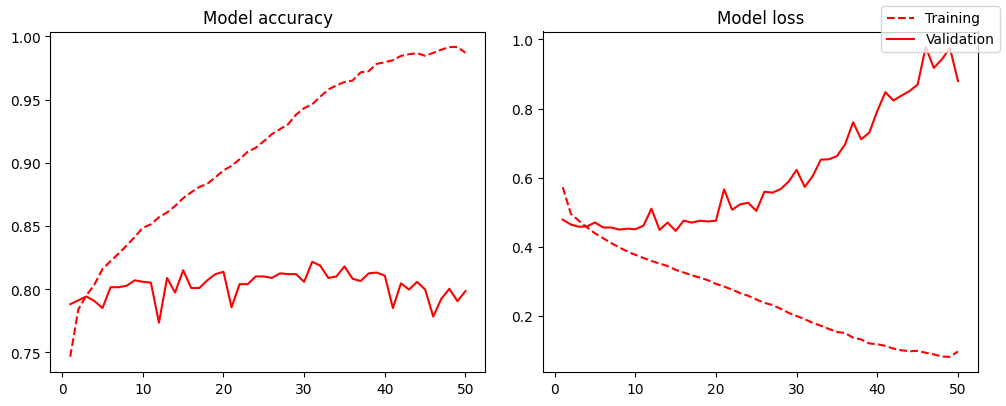

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_74 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 20, 20, 128)       738

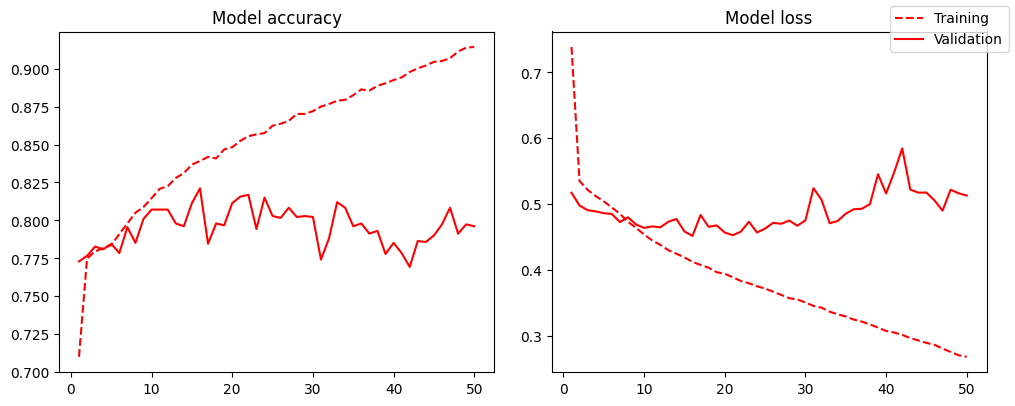

In [17]:
# L2 low reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)

    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

    # ----- Model summary -----
    model.summary()

    # ----- Configure model -----
    model.compile(optimizer=Best_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # ----- Train model -----
    history = model.fit(train,
                        epochs = 50,
                        validation_data= val)

    # ----- Plot performance -----
    plot_hist(history)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_79 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 20, 20, 128)       738

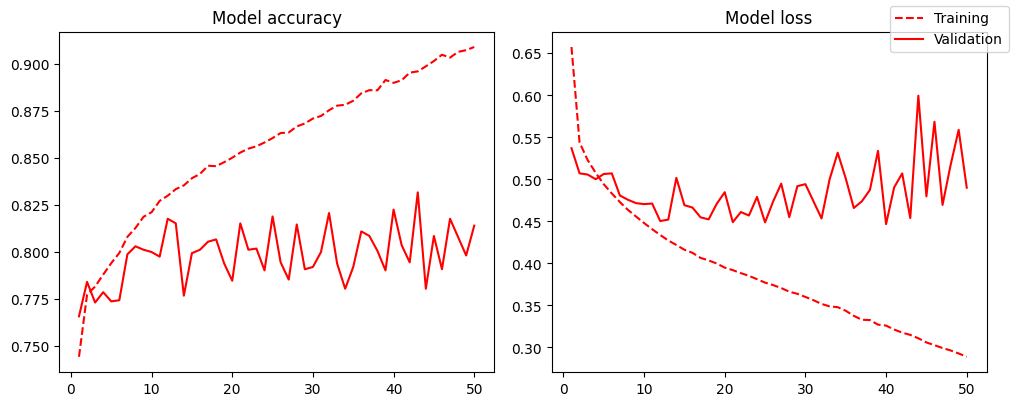

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_84 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 20, 20, 128)       738

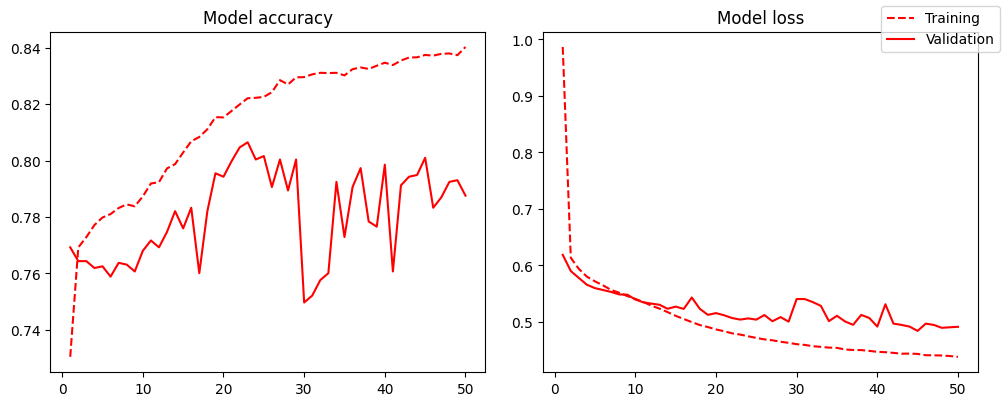

In [18]:
# L2 high reg

for i in l_reg_values: 
    inputs = Input(shape=(96, 96, 3))

    x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(inputs)
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(i))(x)
    x = Flatten()(x)


    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)

    # ----- Model summary -----
    model.summary()

    # ----- Configure model -----
    model.compile(optimizer=Best_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # ----- Train model -----
    history = model.fit(train,
                        epochs = 50,
                        validation_data= val)

    # ----- Plot performance -----
    plot_hist(history)




## New best model

In [19]:
# ----- BEST PENALTY -----
Best_penalty = 0.001

# ----- SIMPLE CNN + L2 REGULARIZATION -----
inputs = Input(shape=(96, 96, 3))

x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(inputs)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(Best_penalty))(x)
x = Flatten()(x)

outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()



Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_89 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 20, 20, 128)       738

## Regularization: Batch normalization 

Batch normalization is added and tested in three different ways:

1. Batch normalization is not included
2. Batch normalization

In [22]:


#x = BatchNormalization()(x) # HUSK kommentar om activation function før/efter batch normalization
#x = Activation('relu')(x)

# ----- SIMPLE CNN + L2 REGULARIZATION -----
inputs = Input(shape=(96, 96, 3))

x = Conv2D(filters=32, kernel_size=3, kernel_regularizer=reg.L2(Best_penalty))(inputs)
x = BatchNormalization()(x) # HUSK kommentar om activation function før/efter batch normalization
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = Flatten()(x)

outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
                    epochs = 50,
                    validation_data= val)

# ----- Plot performance -----
plot_hist(history)




Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_105 (Conv2D)         (None, 45, 45, 64)        184

KeyboardInterrupt: 

## Regularization: Dropout

In [27]:
Best_dropout = 0.2

#### Setup 1 

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_134 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_135 (Conv2D)         (None, 45, 45, 64)        18496     
                                                                 
 spatial_dropout2d_10 (Spati  (None, 45, 45, 64)       0         
 alDropout2D)                                                    
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 22, 22, 64)       0  

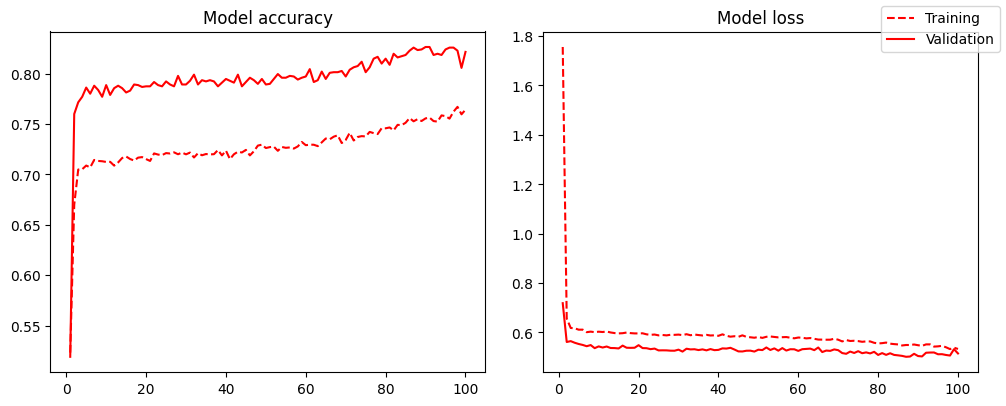

In [30]:
# ----- SIMPLE CNN + L2 REGULARIZATION + DROPOUT(0.2) -----
inputs = Input(shape=(96, 96, 3))

x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(inputs)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = SpatialDropout2D(Best_dropout)(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(Best_penalty))(x)
x = SpatialDropout2D(Best_dropout)(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(Best_penalty))(x)
x = Flatten()(x)

outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

# ----- Model summary -----
model.summary()

# ----- Configure model -----
model.compile(optimizer=Best_optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# ----- Train model -----
history = model.fit(train,
                    epochs = 100,
                    validation_data= val)

# ----- Plot performance -----
plot_hist(history)

#### Activation maps: Heatmap

In [40]:
# New function
def get_heatmap(category, start_image):
    cell_output     = model.get_layer('dense_30').output # output layer
    last_conv_layer = model.get_layer('conv2d_134').output # deep convolution 
                                                         # we could use something else
    submodel = tf.keras.models.Model([model.inputs], [cell_output, last_conv_layer])

    input_img_data = start_image.copy()
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    with tf.GradientTape() as tape:
        outputs_class, outputs_conv = submodel(input_img_data)
        loss_value                  = tf.reduce_mean(outputs_class[:, category])

    grads = tape.gradient(loss_value, outputs_conv)

    cast_outputs_conv = tf.cast(outputs_conv > 0, "float32")
    cast_grads        = tf.cast(grads > 0, "float32")
    guided_grads      = cast_outputs_conv * cast_grads * grads
    outputs_conv      = outputs_conv[0]
    guided_grads      = guided_grads[0]
    
    weights           = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam               = tf.reduce_sum(tf.multiply(weights, outputs_conv), axis=-1)
    
    return cam
    

#### Get sick cells

In [54]:
for images, labels in train.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

numpy_images_2 = []
numpy_labels_2 = []

# Get cancer cells
for label, image in zip(numpy_labels, numpy_images):
    if label[0] == 1: # If true (cancer)
        numpy_images_2.append(image)
        numpy_labels_2.append(1)

#### Create heatmap

In [38]:
from PIL import Image
cmap = plt.get_cmap('jet')

def create_heatmap(idx):
    category, image = numpy_labels_2[idx], numpy_images[idx:(idx + 1)]

    heatmap = get_heatmap(category, image)
    heatmap = heatmap.numpy()
    heatmap = Image.fromarray(heatmap)
    heatmap = heatmap.resize((96, 96), Image.ANTIALIAS)
    #heatmap = heatmap.resize((32, 32), Image.LANCZOS)# 
    heatmap = np.array(heatmap) # back to numpy array
    heatmap = (heatmap / heatmap.max()) # to [0, 1]    
    heatmap = cmap(heatmap)
    heatmap = np.delete(heatmap, 3, 2)

    overlayed_heatmap = 0.6 * image[0] + 0.4 * heatmap
    
    return image[0], heatmap, overlayed_heatmap

def plot_heatmap():
    plt.figure(figsize=(10, 10))
    for i in range(3):
        images = create_heatmap(i)
        for j in range(3):
            ax = plt.subplot(3, 3, i * 3 + 1 + j); plt.axis('off'); plt.imshow(images[j])
    plt.show()

#### Display heatmap

C:\Users\andly\AppData\Local\Temp\ipykernel_2296\1761033284.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap = heatmap.resize((96, 96), Image.ANTIALIAS)


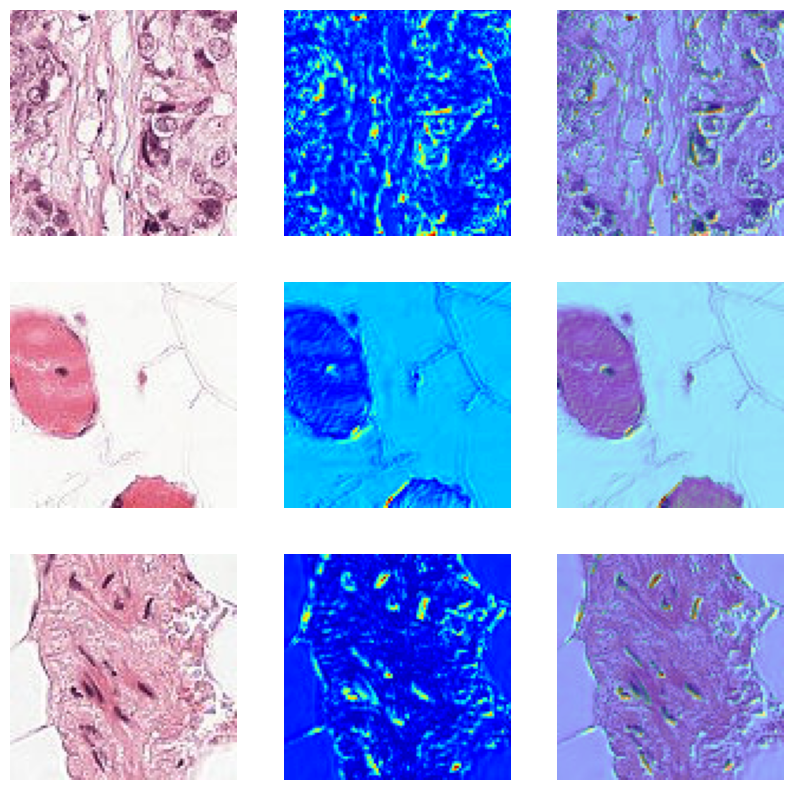

In [55]:
plot_heatmap()